In [1]:
import pandas as pd
import geopandas as gpd

from shapely.geometry import Point, Polygon

# Load Data and Filter down to Study area parcels

In [2]:
bk_prices = pd.read_csv('data/brooklyn_prices.csv', index_col=0)

In [3]:
pluto = gpd.read_file('data/pluto.geojson')

In [4]:
addr = "373 VAN BRUNT STREET"
addr_pluto = pluto[pluto['address'] == addr]

addr_pluto_geometry = addr_pluto['geometry']

addr_coors = [float(addr_pluto_geometry.centroid.y), float(addr_pluto_geometry.centroid.x)]
addr_point =  Point(addr_coors)
print(type(addr_coors[0]))

<class 'float'>


In [18]:
# get study area pluto data
radius = 0.3 # miles
study_area = addr_point.buffer(radius / 69)
study_area_polygon = Polygon(study_area.exterior.coords)

def centroid_to_coor(centroid):
    return Point(centroid.y, centroid.x)

study_area_pluto = pluto[pluto.apply(lambda x: study_area_polygon.contains(centroid_to_coor(x['geometry'].centroid)), axis=1)]
len(study_area_pluto)

646

# Join Rolling Data and Pluto

In [19]:
def format_bbl(parcel):
    borough = str(parcel['BOROUGH'])
    block = str(parcel['BLOCK'])
    lot = str(parcel['LOT'])
    return int(borough + block.zfill(5) + lot.zfill(4))

In [20]:
# Create bbls
bk_prices['BBL'] = bk_prices.apply(format_bbl, axis=1)


In [22]:
study_area_prices = bk_prices[bk_prices.apply(lambda parcel: parcel['BBL'] in study_area_pluto['bbl'].values, axis=1)]

In [ ]:
sold_parcels = study_area_pluto[study_area_pluto.apply(lambda parcel: parcel['bbl'] in study_area_prices['BBL'].values, axis=1)]

# Analyze the study area sales

In [33]:
import matplotlib.pyplot as plt

# how many parcels were sold multiple times
# what are the transactions

In [32]:
list(study_area_prices)

['BOROUGH',
 'NEIGHBORHOOD',
 'BUILDING CLASS CATEGORY',
 'TAX CLASS AT PRESENT',
 'BLOCK',
 'LOT',
 'EASE-MENT',
 'BUILDING CLASS AT PRESENT',
 'ADDRESS',
 'APARTMENT NUMBER',
 'ZIP CODE',
 'RESIDENTIAL UNITS',
 'COMMERCIAL UNITS',
 'TOTAL UNITS',
 'LAND SQUARE FEET',
 'GROSS SQUARE FEET',
 'YEAR BUILT',
 'TAX CLASS AT TIME OF SALE',
 'BUILDING CLASS AT TIME OF SALE',
 'SALE PRICE',
 'SALE DATE',
 'BBL']

# Visualize

In [27]:
import folium
import geopandas
m = folium.Map(location=addr_coors,zoom_start=14,tiles="Stamen Toner")

folium.Circle(addr_coors, radius=radius * 1609.34).add_to(m)

folium.GeoJson(
    sold_parcels['geometry'],
    name='geojson'
).add_to(m)

In [28]:
def style_function(feature):
    return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black'
    }

In [29]:
folium.GeoJson(
    addr_pluto_geometry,
    name='geojson',
    style_function=style_function
).add_to(m)

In [30]:
m

In [39]:
print("{} percent are 0$".format(len(study_area_prices[study_area_prices['SALE PRICE'] == 0]) / len(study_area_prices) * 100))

43.553008595988544 percent are 0$


In [48]:
print(len(study_area_prices))
non_zero_sales = study_area_prices[study_area_prices['SALE PRICE'] != 0]
print(len(non_zero_sales))
non_zero_sales

349
197


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,BBL
24592,3,RED HOOK,01 ONE FAMILY HOMES,1,585,52,,A5,190 COFFEY STREET,,...,0,1,2500,1600,1899,1,A5,188010,2007-06-21,3005850052
24594,3,RED HOOK,01 ONE FAMILY HOMES,1,587,28,,A9,65 DIKEMAN STREET,,...,0,1,1600,2400,1899,1,A9,10,2007-08-20,3005870028
24601,3,RED HOOK,02 TWO FAMILY HOMES,1,556,7,,S2,317 VAN BRUNT STREET,,...,1,3,1575,4160,1921,1,S2,46000,2007-08-23,3005560007
24602,3,RED HOOK,02 TWO FAMILY HOMES,1,577,20,,B9,25 WOLCOTT STREET,,...,0,2,2000,2100,1899,1,B9,5930,2007-05-17,3005770020
24604,3,RED HOOK,02 TWO FAMILY HOMES,1,585,42,,B9,170 COFFEY STREET,,...,0,2,2000,2700,1899,1,B9,875000,2007-04-10,3005850042
24605,3,RED HOOK,02 TWO FAMILY HOMES,1,586,25,,S2,398 VAN BRUNT STREET,,...,1,3,2250,4000,1899,1,S2,1795000,2007-07-20,3005860025
24606,3,RED HOOK,02 TWO FAMILY HOMES,1,586,32,,B9,132 COFFEY STREET,,...,0,2,3000,2322,1899,1,B9,243217,2007-05-02,3005860032
24607,3,RED HOOK,02 TWO FAMILY HOMES,1,587,5,,B9,373 VAN BRUNT STREET,,...,0,2,1900,3345,1899,1,S2,700000,2007-06-26,3005870005
24608,3,RED HOOK,02 TWO FAMILY HOMES,1,588,12,,B1,49 DIKEMAN STREET,,...,0,2,2000,2080,1899,1,B1,745000,2007-07-12,3005880012
24609,3,RED HOOK,02 TWO FAMILY HOMES,1,599,35,,B9,52 VAN DYKE STREET,,...,0,2,2500,1280,1899,1,B9,690000,2007-10-25,3005990035


<module 'matplotlib.pyplot' from '/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

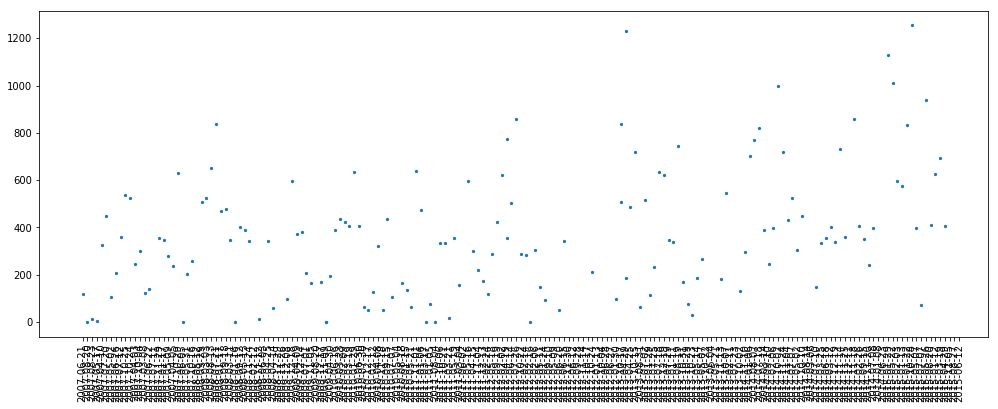

In [57]:
fig = plt.figure(figsize=(17, 6))
plt.scatter(non_zero_sales['SALE DATE'], non_zero_sales['SALE PRICE'] / non_zero_sales['GROSS SQUARE FEET'], s=5)
plt.xticks(rotation=90)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt